In [ ]:
# # 초기 1회 실행
# from google.colab import drive
# drive.mount('/content/drive')

# Lesson 8-2 Deep Learning1_dnn

In [ ]:
## 필요 패키지 설치 및 import
import importlib.util
import subprocess
import sys
def install_and_import(packages):
    for pkg in packages:
        package = pkg
        try:
            importlib.util.find_spec(package)
            print(f"{package} is already installed.")
        except ImportError:
            # 모듈이 설치되어 있지 않은 경우 설치시도
            print(f"{package} is not installed. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            subprocess.check_call(["conda", "install", package, "-y"])

            # 설치 후 다시 임포트를 시도
            importlib.import_module(package)
            print(f"{package} has been successfully installed.")

        # finally:
        #     globals()[package] = importlib.import_module(package)
        except Exception as e:
            # 설치 중 예외가 발생한 경우, 에러 메시지를 출력
            print(f"An error occurred while installing {package}: {str(e)}")

# 예시 사용법
# install_and_import(['', ''])


In [ ]:
ppath = '/content/drive/MyDrive/5. STUDY_ETC/Metacode/lesson8'

In [ ]:
## 필요 모듈 임포트
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import randint, uniform

# Deep Neural Network

## 데이터 읽기

In [ ]:
train = pd.read_csv(ppath + '/1. data/secom_nona_train1.csv')
test = pd.read_csv(ppath + '/1. data/secom_nona_test1.csv')

### 데이터 전처리

In [ ]:
## 시간 포맷 변경
train['datetime'] = pd.to_datetime(train['datetime'], format = "%d/%m/%Y %H:%M:%S")
test['datetime'] = pd.to_datetime( test['datetime'], format = "%d/%m/%Y %H:%M:%S")

## 시간 정보 따로 저장
train_time = train['datetime']
test_time = test['datetime']

## train/test 분리
X_train = train.drop(['datetime',  'target'], axis=1)
y_train = train['target']

X_test = test.drop(['datetime', 'target'], axis=1)
y_test = test['target']

In [ ]:
## 데이터 표준화
from sklearn.preprocessing import StandardScaler, OneHotEncoder

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

def custom_confusion_matrix(y_true, y_pred):

        ## 혼동 행렬 계산
        cm = confusion_matrix(y_true=y_true,
                                                          y_pred=y_pred)
        ## 클래스 1을 기준으로 행과 열 순서 변경
        cm = cm[::-1, ::-1]

        ## 행과 열을 바꾸기 위해 전치(transpose)
        cm_transposed = cm.T
        print(cm_transposed)


        # DataFrame으로 변환 (라벨 추가)
        df_cm = pd.DataFrame(cm_transposed,
                                                      index = ['pred 1', 'pred 0'],
                                                      columns = ['act 1', 'act 0'])

        ## 히트맵 그리기
        plt.figure(figsize = (4,3))
        sns.heatmap(df_cm, annot = True, fmt = 'd', cmap = 'Blues')
        plt.title('Confusion Matrix (Class 1 as Positive)')
        plt.ylabel('Predicted')
        plt.xlabel('Actual')
        plt.show()

## 파이토치

- 재현을 위한 랜덤 시드 고정
  - 랜덤
  - 넘파이
  - 파이토치

In [ ]:
## 재현을 위한 랜덤 시드 고정...
import random
import numpy as np
import torch

## 시드 고정
random.seed(123)                 # Python 기본 랜덤 시드 고정
np.random.seed(123)           # NumPy 랜덤 시드 고정
torch.manual_seed(123)     # PyTorch CPU 시드 고정

## GPU가 있는 경우 시드 고정, GPU 연산에서 사용되는 난수 생성기의 시드를 고정
if torch.cuda.is_available():
    torch.cuda.manual_seed(123)
    torch.cuda.manual_seed_all(123)  # 모든 GPU에서 시드 고정

## CuDNN 설정 (GPU 사용 시), CuDNN 라이브러리의 비결정적 연산을 방지,  동일한 결과를 얻기 위한 설정..
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


### 파이토치 데이터 형식으로 변환
- df, np.array to Tensor 형태

In [ ]:
## PyTorch 데이터셋으로 변환
X_train_tensor = torch.FloatTensor(X_train_scaled) # df라면, df.toarray() 필요
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1)  # unsqueeze: 형태를 (n_samples, 1)로 변경
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)

### 모델 정의

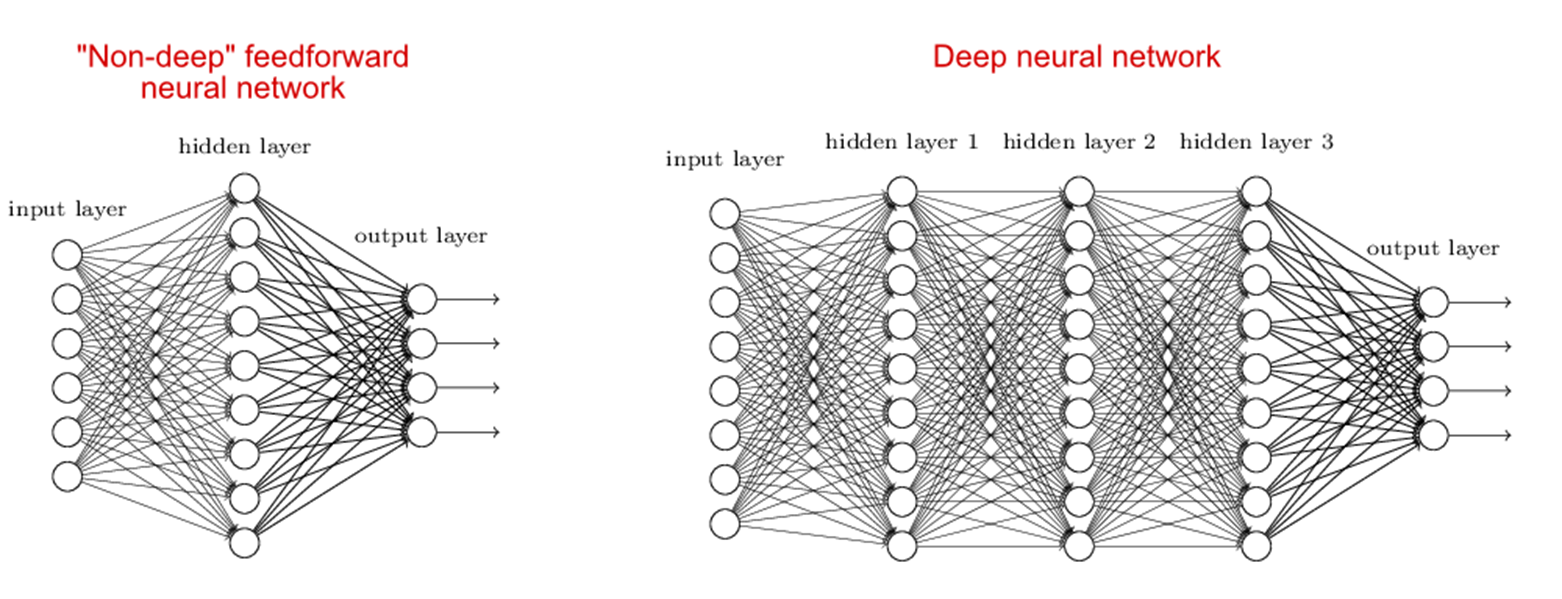

In [ ]:
## DNN 모델 클래스 정의 (유연한 레이어 구성)
class DNN(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_units, output_size = 1):
        super(DNN, self).__init__()

        # 입력층 정의
        layers = []
        current_input_size = input_size

        # 숨겨진 레이어 추가 (사용자가 정의한 레이어와 노드 수 사용)
        for i in range(hidden_layers):
            x  = nn.Linear(current_input_size, hidden_units[i])
            layers.append(x)
            y = nn.ReLU() # 활성화 함수: ReLU
            layers.append(y)
            current_input_size = hidden_units[i]

        # 출력층 정의 (이진 분류: 출력 1개, 활성화 함수 없이 사용)
        x = nn.Linear(current_input_size, output_size)
        layers.append(x)
        y = nn.Sigmoid() # 이진 분류를 위한 시그모이드 활성화 함수
        layers.append(y)

        # 모델 구성
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

### 모델 초기화

In [ ]:
## 사용자 입력에 따른 모델 정의
input_size = X_train.shape[1]   # 입력 특성 개수
hidden_layers = 4                          # 히든 레이어 개수 (사용자가 정의 가능)
hidden_units = [64, 32, 16, 8]   # 각 히든 레이어의 노드 수 (사용자가 정의 가능)
output_size = 1                               # 이진 분류이므로 출력 크기는 1


## 모델 초기화 함수 정의
def initialize_model(input_size, hidden_layers, hidden_units, output_size = 1):
    # 모델 생성
    model = DNN(input_size, hidden_layers, hidden_units, output_size)
    return model


## 모델 초기화
model = initialize_model(input_size, hidden_layers, hidden_units, output_size)
model

DNN(
  (model): Sequential(
    (0): Linear(in_features=590, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

### 트레이닝 함수 정의

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

## 학습 함수 정의
def train_model(model: nn.Module,
                                  train_loader: DataLoader,
                                  criterion: nn.Module,
                                  optimizer: optim.Optimizer,
                                  num_epochs: int):
    loss_history = [] # 에폭에 따른 로스 저장할 리스트 생성

    for epoch in range(num_epochs):      # 각 에폭마다
        model.train() # 모델을 학습모드로 전환
        running_loss = 0.0  # 에폭 동안의 누적 손실 초기화

        for inputs, targets in train_loader:  # batch 별로

            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # 역전파
            optimizer.zero_grad()  # 기존 그래디언트 초기화 (위치는 순전파 이후! 역전파 이전!  손실을 계산한 후, 손실의 기울기를 계산하기 전에 기존의 그래디언트를 초기화..)
            loss.backward()              # 역전파 수행 (자동 미분)
            optimizer.step()              # 가중치 업데이트

            running_loss += loss.item()  # 배치 손실 누적

        # 에폭별 평균 손실 계산
        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)  # 에폭별 로스 기록
        print(f'Epoch: [{epoch+1}/{num_epochs}], Loss: {loss.item(): .4f}')

    return loss_history, model # 학습된 모델 반환

### 가중치 초기화

In [ ]:
import torch.nn.init as init

## xavier 가중치 초기화
# sigmoid, tanh 등 특정 경우
def initialize_weights_xavier(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)   # 가중치를 xavier 초기화로 재설정
        if m.bias is not None:
            nn.init.zeros_(m.bias)                         # 편향은 0으로 초기화

## He 초기화 함수 정의
# relu 계열, 딥러닝에 더 적합
def initialize_weights_he(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, nonlinearity = 'relu')  # He 초기화 (uniform 분포)
        if m.bias is not None:
            init.zeros_(m.bias)                                                                       # 편향은 0으로 초기화



## 순서는 모델 초기화 -> 가중치 초기화 -> 옵티마이져 초기화 !!!!!
model.apply(initialize_weights_he)  # 가중치 초기화

DNN(
  (model): Sequential(
    (0): Linear(in_features=590, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

### 손실 함수와 옵티마이저 정의


In [ ]:
## 손실 함수
criterion = nn.BCELoss() ##  BCE(Binary Cross Entropy Loss)

## 옵티마이저
## adam > = Nadam(adam의 약간 개선 버전) == adadelta(메모리 문제있으면)
optimizer = optim.Adam(
        model.parameters(),   # 모델의 학습 가능한 파라미터 전달
        lr = 0.01,                            # learning rate, 파라미터 업데이트의 크기를 결정, 기본값은 0.001
        weight_decay = 0,           # 가중치 감쇠 (L2 규제, weight decay), 기본값은 0
        amsgrad = False               # AMSGrad 알고리즘을 사용할지 여부, 기본값은 False
)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

### 데이터 로더
- 데이터를 미니 배치 단위로 나누어 모델에 공급(feed) 하는 방법
- 셔플, 병렬 처리 등을 지원하며, 학습 속도를 최적화할때 필요
- 배치크기 정하기..
  - 보통 2의 승수로 선택 64, 128, 1024 등
  - 왕도가 없음..

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

## 데이터로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset,
                                                       batch_size = 64,
                                                       shuffle = True,
                                                       num_workers = 2) # 멀티쓰레딩, CPU 코어개수.. '-1'은 오류..주의

In [ ]:
## CPU 코어 개수 출력
cpu_cores = os.cpu_count()
cpu_cores

2

### 모델 학습
- 중요 순서는 __모델 초기화 -> 가중치 초기화 -> 옵티마이져 초기화__

In [ ]:
## 모델 학습
num_epochs = 60

## 재학습시에는 모델 + 옵치마이져 초기화 를 꼭 해줘야 함!!!!
# model = MLP(input_size, hidden_size, output_size)
# optimizer = optim.Adam(
#         model.parameters(),      # 모델의 학습 가능한 파라미터 전달
#         lr = 0.01,                               # learning rate, 파라미터 업데이트의 크기를 결정, 기본값은 0.001
#         weight_decay = 0,           # 가중치 감쇠 (L2 규제, weight decay), 기본값은 0
#         amsgrad = False               # AMSGrad 알고리즘을 사용할지 여부, 기본값은 False
# )
## 그렇지 않으면 이전 학습에서 이미 학습한 가중치를 기반으로 계속 업데이트하게됨...이상한 결과가 나올 수 있다..

loss_history, trained_model = train_model(model = model,
                                                                                          train_loader = train_loader,
                                                                                          criterion = criterion,
                                                                                          optimizer = optimizer,
                                                                                          num_epochs = num_epochs)
loss_history, trained_model

Epoch: [1/60], Loss:  0.2755
Epoch: [2/60], Loss:  0.1670
Epoch: [3/60], Loss:  0.0686
Epoch: [4/60], Loss:  0.0405
Epoch: [5/60], Loss:  0.0543
Epoch: [6/60], Loss:  0.0865
Epoch: [7/60], Loss:  0.1247
Epoch: [8/60], Loss:  0.0205
Epoch: [9/60], Loss:  0.0272
Epoch: [10/60], Loss:  0.0168
Epoch: [11/60], Loss:  0.0793
Epoch: [12/60], Loss:  0.0045
Epoch: [13/60], Loss:  0.4865
Epoch: [14/60], Loss:  0.0490
Epoch: [15/60], Loss:  0.0283
Epoch: [16/60], Loss:  0.0579
Epoch: [17/60], Loss:  0.0623
Epoch: [18/60], Loss:  0.0006
Epoch: [19/60], Loss:  0.0153
Epoch: [20/60], Loss:  0.0069
Epoch: [21/60], Loss:  0.0159
Epoch: [22/60], Loss:  0.0557
Epoch: [23/60], Loss:  0.0134
Epoch: [24/60], Loss:  0.0107
Epoch: [25/60], Loss:  0.0005
Epoch: [26/60], Loss:  0.0099
Epoch: [27/60], Loss:  0.0003
Epoch: [28/60], Loss:  0.0097
Epoch: [29/60], Loss:  0.0186
Epoch: [30/60], Loss:  0.0286
Epoch: [31/60], Loss:  0.0001
Epoch: [32/60], Loss:  0.0087
Epoch: [33/60], Loss:  0.0170
Epoch: [34/60], Los

([0.3579877277037927,
  0.20701462562595094,
  0.1344055212324574,
  0.0926688974279733,
  0.07946662560460113,
  0.05951518884726933,
  0.04957433311002595,
  0.03528388279179732,
  0.04772834626159498,
  0.04346131077701492,
  0.03929442601899306,
  0.03632182675279355,
  0.08037019836982447,
  0.08994530584840547,
  0.06826501816422456,
  0.04009699830341907,
  0.03728338547738358,
  0.10404057357144277,
  0.013755933654638716,
  0.021359474706153424,
  0.03660573339965638,
  0.025953997275792062,
  0.0185874560626135,
  0.018465041576529898,
  0.009633579607041264,
  0.009823895927097294,
  0.0092604459304788,
  0.009023303545940766,
  0.008818309709697911,
  0.008802662346992986,
  0.008406948600990984,
  0.008387695054980646,
  0.008376188463530741,
  0.00819078848432279,
  0.008030247596685686,
  0.007937384572176683,
  0.007940972134465915,
  0.007850217322243225,
  0.007715470328310489,
  0.007711936045238656,
  0.007573220356096586,
  0.007517570618320167,
  0.007692030671954

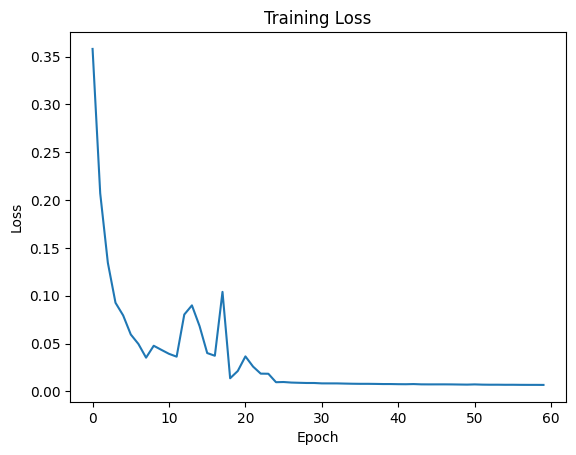

In [ ]:
## 에폭~Loss 그래프 그리기
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 테스트데이터에 적용

Test Accuracy: 0.9280
[[  3   4]
 [ 13 216]]


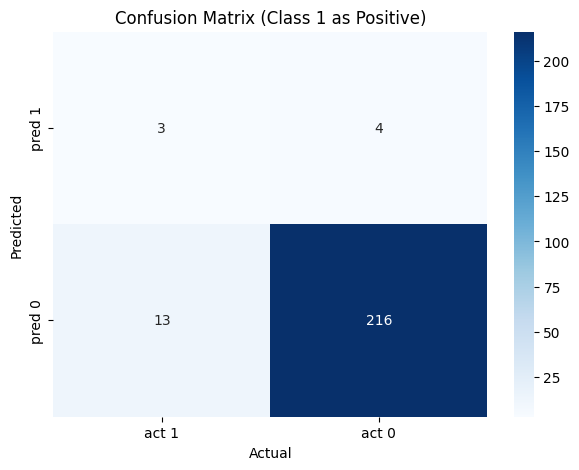


Classification Report:
              precision    recall  f1-score   support

           0     0.9432    0.9818    0.9621       220
           1     0.4286    0.1875    0.2609        16

    accuracy                         0.9280       236
   macro avg     0.6859    0.5847    0.6115       236
weighted avg     0.9083    0.9280    0.9146       236



In [ ]:
## 모델 Inference, (모델 평가라고 부르기도..)
trained_model.eval() # 평가모드로 전환

## 그레디언트 계산 비 활성화 후 계산만..
with torch.no_grad(): # 특정 코드 블록의 실행 전후에 특별한 동작을 정의

    # 모델 예측
    y_pred = trained_model(X_test_tensor)

    # 확률 값을 클래스 값으로 변경
    y_pred_class = (y_pred > 0.5).float() # 0.5보다 크면 1로 변환, 아니면 0

    # 정확도 계산
    accuracy = accuracy_score(y_test, y_pred_class)
    print(f'Test Accuracy: {accuracy:.4f}')

    custom_confusion_matrix(y_test, y_pred_class)

    print('\nClassification Report:')
    print(classification_report(y_test, y_pred_class, digits = 4))

## 참고


###  파라미터 갯수 , 가중치 출력하기

In [ ]:
## 파라미터 개수를 계산하는 함수 정의
def count_parameters(model):
    # 모델의 학습 가능한 파라미터 중, 각각의 파라미터의 요소 개수를 모두 더하기
    params = [param.numel() for param in model.parameters() if param.requires_grad]
    output = sum(params)

    return output

## 모델의 총 학습 가능한 파라미터 수를 계산하여 출력
total_params = count_parameters(trained_model)
print('Total parameters:' , total_params )

Total parameters: 40577


In [ ]:
## 모델의 가중치와 편향을 출력하고, 각 레이어별 파라미터 정보를 출력하는 코드
for name, params in trained_model.named_parameters(): # 모델의 모든 파라미터를 이름과 함께 반환..

    if params.requires_grad:  # 파라미터가 학습 가능한 경우 (requires_grad=True)
        # 레이어 이름, 파라미터의 크기(모양), 파라미터 값 일부를 출력
        print(f'Layer: {name} \n | Size: {params.size()} \n | Values : {params[:2]}\n')


Layer: model.0.weight 
 | Size: torch.Size([64, 590]) 
 | Values : tensor([[ 0.2156,  0.0515,  0.3354,  ..., -0.0518,  0.0665, -0.0448],
        [ 0.1937, -0.2441, -0.1287,  ...,  0.1771,  0.0930,  0.4283]],
       grad_fn=<SliceBackward0>)

Layer: model.0.bias 
 | Size: torch.Size([64]) 
 | Values : tensor([0.0869, 0.0439], grad_fn=<SliceBackward0>)

Layer: model.2.weight 
 | Size: torch.Size([32, 64]) 
 | Values : tensor([[-0.3464, -0.2994, -0.1403, -0.2111, -0.1134, -0.2555, -0.1998, -0.3129,
         -0.2908,  0.1403, -0.2686,  0.0065,  0.1321, -0.1858,  0.2507,  0.0346,
         -0.3103,  0.0651, -0.2375, -0.1939, -0.2044,  0.0214,  0.0869, -0.0097,
         -0.1191,  0.0661,  0.1636, -0.1391, -0.3121, -0.1833,  0.0796,  0.1238,
         -0.2832, -0.2261, -0.0924, -0.1688,  0.0518,  0.0536, -0.0496, -0.2508,
          0.1999, -0.0659,  0.2129, -0.1462,  0.0148, -0.0902, -0.3396, -0.3059,
         -0.1217,  0.1285, -0.0795, -0.2190,  0.2091, -0.2413, -0.2277, -0.0404,
          0.0

### 변수 중요도 계산하기

2. Permutation
  - 퍼뮤테이션을 사용하여(특정 변수만 랜덤하게 섞기), 모델의 성능변화로 변수 중요도 추정
  - 모델 상관없이 적용 가능
  - 특성 간 상호작용을 다소.. 고려함
단점: 계산 비용이 높을 수 있음
3. SHAP (SHapley Additive exPlanations)
  - 게임 이론을 기반으로 각 특성의 기여도를 계산
  - 매우 정확하고 해석 가능한 결과 제공, 특성 간 상호작용을 잘 고려함
 - 계산 비용이 매우 높음, 구현이 복잡할 수 있음

DNN에서는 2,3번 사용가능..

In [ ]:
## 퍼뮤테이션 함수 정의
def permutation_importance_dnn_dense(model, X_test_tensor, y, n_repeats = 5):

    model.eval()  # 모델을 평가 모드로 설정

    # baseline 성능 (모든 특성이 있는 상태에서 정확도)
    baseline_accuracy = accuracy_score(y, (model(X_test_tensor).detach().numpy() > 0.5).astype(int))

    # 특성 중요도 리스트
    importances = []

    # 각 특성(column)에 대해 반복
    for column in range(X_test_tensor.shape[1]):
        feature_importance = []

        # 각 특성(column)을 n_repeats 만큼 섞어서 평가
        for _ in range(n_repeats):
            X_permuted = X_test_tensor.clone()  # 데이터를 복사
            perm = np.random.permutation(X_permuted.shape[0])

            # 해당 컬럼을 무작위로 섞음
            X_permuted[:, column] = X_permuted[perm, column]

            # 섞인 데이터를 텐서로 변환
            X_permuted_tensor = torch.FloatTensor(X_permuted)

            # Permutation 후 모델의 정확도 계산
            permuted_accuracy = accuracy_score(y, (model(X_permuted_tensor).detach().numpy() > 0.5).astype(int))

            # 원래 성능에서 Permutation 후 성능 차이를 저장
            feature_importance.append(baseline_accuracy - permuted_accuracy)

        # 각 특성의 평균 성능 차이를 변수 중요도로 저장
        importances.append(np.mean(feature_importance))

    return np.array(importances)

## 변수 중요도 계산
importance_scores = permutation_importance_dnn_dense(trained_model, X_test_tensor, y_test.values)

## 결과 출력
feature_names = [f"X_{i}" for i in range(X_test_tensor.shape[1])]  # 실제 특성 이름이 있다면 그것을 사용
for name, score in zip(feature_names, importance_scores):
    print(f"{name}: {score}")

X_0: 0.007627118644067776
X_1: 0.0025423728813559255
X_2: 0.003389830508474567
X_3: 0.0
X_4: 0.0
X_5: 0.0
X_6: 0.0
X_7: 0.0
X_8: 0.005932203389830493
X_9: 0.0025423728813559255
X_10: 0.005084745762711851
X_11: 0.0
X_12: 0.0008474576271186418
X_13: 0.0
X_14: 0.0008474576271186418
X_15: 0.004237288135593209
X_16: 0.0
X_17: 0.0
X_18: 0.0025423728813559255
X_19: 0.0008474576271186418
X_20: 0.0008474576271186418
X_21: 0.0016949152542372835
X_22: 0.0
X_23: 0.0008474576271186418
X_24: 0.005084745762711851
X_25: 0.0
X_26: 0.0016949152542372835
X_27: 0.0016949152542372835
X_28: 0.003389830508474567
X_29: 0.005932203389830493
X_30: 0.005084745762711851
X_31: 0.0
X_32: 0.005932203389830493
X_33: 0.0
X_34: -0.0008474576271186418
X_35: 0.0
X_36: 0.0025423728813559255
X_37: 0.005084745762711851
X_38: 0.004237288135593209
X_39: 0.0016949152542372835
X_40: 0.0016949152542372835
X_41: 0.0
X_42: 0.0
X_43: 0.003389830508474567
X_44: 0.0025423728813559255
X_45: 0.004237288135593209
X_46: 0.001694915254237

In [ ]:
## 변수 이름 설정
feature_names = ["X_" + str(i)  for i in range(X_test_tensor.shape[1])]

## 중요도를 기준으로 내림차순 정렬한 인덱스 가져오기
sorted_indices = np.argsort(importance_scores)[::-1]  # 내림차순 정렬

## 상위 10개 중요도 출력
print("상위 10 중요변수")
for idx in sorted_indices[:10]:
    print(f"{feature_names[idx]}: {importance_scores[idx]}")

## 하위 5개 중요도 출력
print("\n 하위 5개 변수:")
for idx in sorted_indices[-5:]:
    print(f"{feature_names[idx]}: {importance_scores[idx]}")

상위 10 중요변수
X_129: 0.01864406779661012
X_75: 0.010169491525423702
X_82: 0.008474576271186418
X_0: 0.007627118644067776
X_351: 0.007627118644067776
X_111: 0.007627118644067776
X_579: 0.007627118644067776
X_59: 0.006779661016949134
X_132: 0.006779661016949134
X_145: 0.006779661016949134

 하위 5개 변수:
X_62: -0.0008474576271186418
X_521: -0.0008474576271186418
X_34: -0.0008474576271186418
X_136: -0.0008474576271186418
X_349: -0.0025423728813559255


## 하이퍼파라미터 최적화

#### 랜덤서치

- 랜덤 서치1
  - GridSearchCV보다 효율적
  - 더 넓은 파라미터 공간을 탐색 할 수 있어서, 최적값을 찾을 확률이 다소 더 높음..

In [ ]:
## 평가 함수
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_class = (y_pred > 0.5).float()
        accuracy = accuracy_score(y_test.numpy(), y_pred_class.numpy())
    return accuracy


## 랜덤 하이퍼파라미터 생성 함수
def get_random_hyperparameters():
    return {
        'hidden_size': random.randint(15, 100),
        'learning_rate': random.choice([0.001, 0.01, 0.1]),
        'batch_size': random.choice([32, 64, 128]),
        'epochs': random.randint(20, 60)
    }

## 랜덤 서치 하이퍼파라미터 튜닝
n_iter = 20  # 랜덤 서치 반복 횟수
best_accuracy = 0
best_params = {}
best_model = None

for _ in range(n_iter):
    # 랜덤 하이퍼파라미터 선택
    params = get_random_hyperparameters()

    # 모델 초기화
    model = initialize_model(input_size, hidden_layers, hidden_units, output_size)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    # 데이터 로더 생성
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    # 모델 훈련
    loss_history, model = train_model(model, train_loader, criterion, optimizer, params['epochs'])

    # 모델 평가
    accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
    print("accuracy:", accuracy, "\n")

    # 최고 성능 모델 저장
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params
        best_model = model

print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)
print("Best model:", best_model)

Epoch: [1/46], Loss:  0.1368
Epoch: [2/46], Loss:  0.0263
Epoch: [3/46], Loss:  0.0359
Epoch: [4/46], Loss:  0.0363
Epoch: [5/46], Loss:  0.0392
Epoch: [6/46], Loss:  0.0001
Epoch: [7/46], Loss:  0.0234
Epoch: [8/46], Loss:  0.0564
Epoch: [9/46], Loss:  0.1165
Epoch: [10/46], Loss:  0.0224
Epoch: [11/46], Loss:  0.0018
Epoch: [12/46], Loss:  0.0006
Epoch: [13/46], Loss:  0.0000
Epoch: [14/46], Loss:  0.0000
Epoch: [15/46], Loss:  0.0000
Epoch: [16/46], Loss:  0.0001
Epoch: [17/46], Loss:  0.0002
Epoch: [18/46], Loss:  0.0000
Epoch: [19/46], Loss:  0.0000
Epoch: [20/46], Loss:  0.0000
Epoch: [21/46], Loss:  0.0000
Epoch: [22/46], Loss:  0.0000
Epoch: [23/46], Loss:  0.0000
Epoch: [24/46], Loss:  0.0000
Epoch: [25/46], Loss:  0.0000
Epoch: [26/46], Loss:  0.0000
Epoch: [27/46], Loss:  0.0000
Epoch: [28/46], Loss:  0.0000
Epoch: [29/46], Loss:  0.0000
Epoch: [30/46], Loss:  0.0000
Epoch: [31/46], Loss:  0.0000
Epoch: [32/46], Loss:  0.0000
Epoch: [33/46], Loss:  0.0000
Epoch: [34/46], Los

- 랜덤 서치2
  - 랜덤 서치 1 + f1 score로 변경 +  DNN 구조까지..
  

In [ ]:
from sklearn.metrics import f1_score

## 평가 함수
def evaluate_model2(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred_class = (y_pred > 0.5).float()

        f1_val  = f1_score(y_test.numpy(),  y_pred_class.numpy())

    return f1_val

In [ ]:
##  랜덤 하이퍼파라미터 생성 함수 정의 (DNN 구조까지 포함)
def get_random_hyperparameters():
    learning_rate = random.uniform(0.0001, 0.01)
    batch_size = random.choice([32, 64, 128, 256])
    epochs = random.choice([10, 20, 30, 50])

    # DNN 구조 관련 하이퍼파라미터
    hidden_layers = random.randint(1, 5)  # 히든 레이어 개수 (1~5개)
    hidden_units = [random.choice([16, 32, 64, 128]) for _ in range(hidden_layers)]  # 각 레이어의 노드 수를 무작위로 선택

    return {
        'learning_rate': learning_rate,
        'batch_size': batch_size,
        'epochs': epochs,
        'hidden_layers': hidden_layers,
        'hidden_units': hidden_units
    }

    output_size = 1  # 이진 분류이므로 출력 크기는 1

# 랜덤 서치 하이퍼파라미터 튜닝
n_iter = 20  # 랜덤 서치 반복 횟수
best_accuracy = 0
best_F1_score = 0
best_params = {}
best_model = None

for _ in range(n_iter):
    # 랜덤 하이퍼파라미터 선택
    params = get_random_hyperparameters()

    # 모델 초기화 (DNN 구조 반영)
    model = initialize_model(input_size, params['hidden_layers'], params['hidden_units'], output_size)

    # 손실 함수와 옵티마이저 정의
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    # 데이터 로더 생성
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

    # 모델 훈련
    loss_history, model = train_model(model, train_loader, criterion, optimizer, params['epochs'])

    # 모델 평가
    # accuracy = evaluate_model(model, X_test_tensor, y_test_tensor)
    # print(f"accuracy: {accuracy}, layers: {params['hidden_layers']}, units: {params['hidden_units']}\n")

    # # 최고 성능 모델 저장
    # if accuracy > best_accuracy:
    #     best_accuracy = accuracy
    #     best_params = params
    #     best_model = model

    # 모델 평가
    F1_score =  evaluate_model2(model, X_test_tensor, y_test_tensor)
    print(f"F1_score: {F1_score}, layers: {params['hidden_layers']}, units: {params['hidden_units']}\n")

    # 최고 성능 모델 저장
    if F1_score > best_F1_score:
        best_F1_score = F1_score
        best_params = params
        best_model = model




Epoch: [1/50], Loss:  0.2131
Epoch: [2/50], Loss:  0.0567
Epoch: [3/50], Loss:  0.2570
Epoch: [4/50], Loss:  0.0573
Epoch: [5/50], Loss:  0.0649
Epoch: [6/50], Loss:  0.0115
Epoch: [7/50], Loss:  0.3278
Epoch: [8/50], Loss:  0.0004
Epoch: [9/50], Loss:  0.0290
Epoch: [10/50], Loss:  0.0241
Epoch: [11/50], Loss:  0.0033
Epoch: [12/50], Loss:  0.0036
Epoch: [13/50], Loss:  0.0093
Epoch: [14/50], Loss:  0.0002
Epoch: [15/50], Loss:  0.0000
Epoch: [16/50], Loss:  0.0001
Epoch: [17/50], Loss:  0.0002
Epoch: [18/50], Loss:  0.0000
Epoch: [19/50], Loss:  0.0000
Epoch: [20/50], Loss:  0.0014
Epoch: [21/50], Loss:  0.0000
Epoch: [22/50], Loss:  0.0000
Epoch: [23/50], Loss:  0.0000
Epoch: [24/50], Loss:  0.0000
Epoch: [25/50], Loss:  0.0000
Epoch: [26/50], Loss:  0.0018
Epoch: [27/50], Loss:  0.0000
Epoch: [28/50], Loss:  0.0000
Epoch: [29/50], Loss:  0.0000
Epoch: [30/50], Loss:  0.0000
Epoch: [31/50], Loss:  0.0000
Epoch: [32/50], Loss:  0.0000
Epoch: [33/50], Loss:  0.0000
Epoch: [34/50], Los

In [ ]:
## 최적 하이퍼파라미터 출력
print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)
print("Best F1_score:", F1_score)
print("Best model:", best_model)

Best parameters: {'learning_rate': 0.0054216101373063125, 'batch_size': 64, 'epochs': 30, 'hidden_layers': 4, 'hidden_units': [64, 32, 64, 16]}
Best accuracy: 0
Best F1_score: 0.3243243243243243
Best model: DNN(
  (model): Sequential(
    (0): Linear(in_features=590, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Linear(in_features=16, out_features=1, bias=True)
    (9): Sigmoid()
  )
)


- 랜덤서치3
  - - 랜덤 서치 1 + f1 score로 변경 +  DNN 구조 + CV...

In [ ]:
from sklearn.model_selection import KFold

## 교차검증을 적용한 하이퍼파라미터 튜닝
n_iter = 20  # 랜덤 서치 횟수
best_f1_score = 0
best_params = {}
best_model = None

## KFold 교차검증 설정 (CV = 3)
kf = KFold(n_splits = 3, shuffle = True, random_state = 123)

for _ in range(n_iter):
    # 랜덤 하이퍼파라미터 선택
    params = get_random_hyperparameters()

    fold_accuracies = []

    # KFold로 데이터를 나눠서 교차검증 진행
    for train_index, val_index in kf.split(X_train_tensor):
        X_train_fold, X_val_fold = X_train_tensor[train_index], X_train_tensor[val_index]
        y_train_fold, y_val_fold = y_train_tensor[train_index], y_train_tensor[val_index]

        # 모델 초기화
        model = initialize_model(input_size, len(params['hidden_units']), params['hidden_units'], output_size)

        # 손실 함수와 옵티마이저 정의
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        # 데이터 로더 생성
        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

        # 모델 훈련
        loss_history, model = train_model(model, train_loader, criterion, optimizer, params['epochs'])

        # # 모델 평가 (검증 데이터 사용)
        # accuracy = evaluate_model(model, X_val_fold, y_val_fold)
        # fold_accuracies.append(accuracy)


        # 모델 평가
        F1_score =  evaluate_model2(model, X_val_fold, y_val_fold)
        fold_accuracies.append(F1_score)
        print(f"F1_score: {F1_score}, layers: {params['hidden_layers']}, units: {params['hidden_units']}\n")

    # 폴드별 평균 정확도 계산
    mean_f1_score = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Mean F1_score for current iteration: {mean_f1_score}")

    # 최고 성능 모델 저장
    if mean_f1_score > best_f1_score:
        best_f1_score = mean_f1_score
        best_params = params
        best_model = model


Epoch: [1/50], Loss:  0.0985
Epoch: [2/50], Loss:  0.1983
Epoch: [3/50], Loss:  0.1108
Epoch: [4/50], Loss:  0.1668
Epoch: [5/50], Loss:  0.0191
Epoch: [6/50], Loss:  0.0513
Epoch: [7/50], Loss:  0.0252
Epoch: [8/50], Loss:  0.0597
Epoch: [9/50], Loss:  0.0459
Epoch: [10/50], Loss:  0.0570
Epoch: [11/50], Loss:  0.0427
Epoch: [12/50], Loss:  0.0509
Epoch: [13/50], Loss:  0.0507
Epoch: [14/50], Loss:  0.0575
Epoch: [15/50], Loss:  0.0282
Epoch: [16/50], Loss:  0.0129
Epoch: [17/50], Loss:  0.0510
Epoch: [18/50], Loss:  0.1217
Epoch: [19/50], Loss:  0.0919
Epoch: [20/50], Loss:  0.0744
Epoch: [21/50], Loss:  0.0239
Epoch: [22/50], Loss:  0.0424
Epoch: [23/50], Loss:  0.0360
Epoch: [24/50], Loss:  0.0033
Epoch: [25/50], Loss:  0.0026
Epoch: [26/50], Loss:  0.0003
Epoch: [27/50], Loss:  0.0000
Epoch: [28/50], Loss:  0.0002
Epoch: [29/50], Loss:  0.0002
Epoch: [30/50], Loss:  0.0001
Epoch: [31/50], Loss:  0.0000
Epoch: [32/50], Loss:  0.0001
Epoch: [33/50], Loss:  0.0001
Epoch: [34/50], Los

In [ ]:
## 최적 하이퍼파라미터 출력
print("Best parameters:", best_params)
print("Best F1_score:", best_f1_score)
print("Best model:", best_model)
## 사실 더 엄밀하게 한다면..Loss 부터 바꿔야...

Best parameters: {'learning_rate': 0.00733461568265337, 'batch_size': 256, 'epochs': 30, 'hidden_layers': 2, 'hidden_units': [64, 16]}
Best F1_score: 0.23625730994152047
Best model: DNN(
  (model): Sequential(
    (0): Linear(in_features=590, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


### 최적화 모델의 결과 확인

Test Accuracy: 0.9280
[[  2   3]
 [ 14 217]]


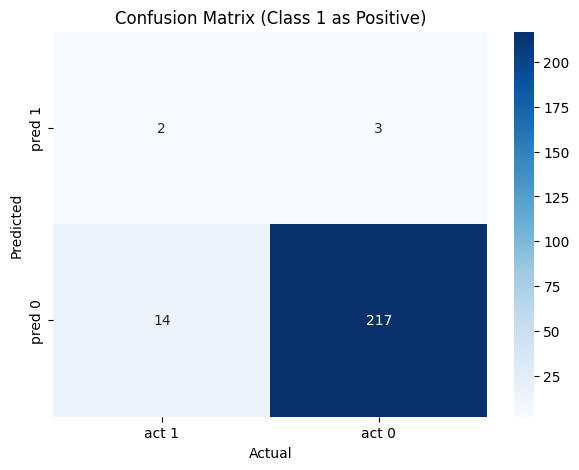


Classification Report:


,0,1,accuracy,macro avg,weighted avg
precision,0.939394,0.400000,0.927966,0.669697,0.902825
recall,0.986364,0.125000,0.927966,0.555682,0.927966
f1-score,0.962306,0.190476,0.927966,0.576391,0.909979
support,220.000000,16.000000,0.927966,236.000000,236.000000


In [ ]:
## 모델 Inference, (모델 평가라고 부르기도..)
best_model.eval() # 평가모드로 전환

## 그레디언트 계산 비 활성화 후 계산만..
with torch.no_grad(): # 특정 코드 블록의 실행 전후에 특별한 동작을 정의

    # 모델 예측
    y_pred = best_model(X_test_tensor)

    # 확률 값을 클래스 값으로 변경
    y_pred_class = (y_pred > 0.5).float() # 0.5보다 크면 1로 변환, 아니면 0

    # 정확도 계산
    accuracy = accuracy_score(y_test, y_pred_class)
    print(f'Test Accuracy: {accuracy:.4f}')

    custom_confusion_matrix(y_test, y_pred_class)

    print('\nClassification Report:')
    report = (classification_report(y_test, y_pred_class, digits = 4, output_dict=True) )
pd.DataFrame(report)

### 참고)AutoML h2o 결과

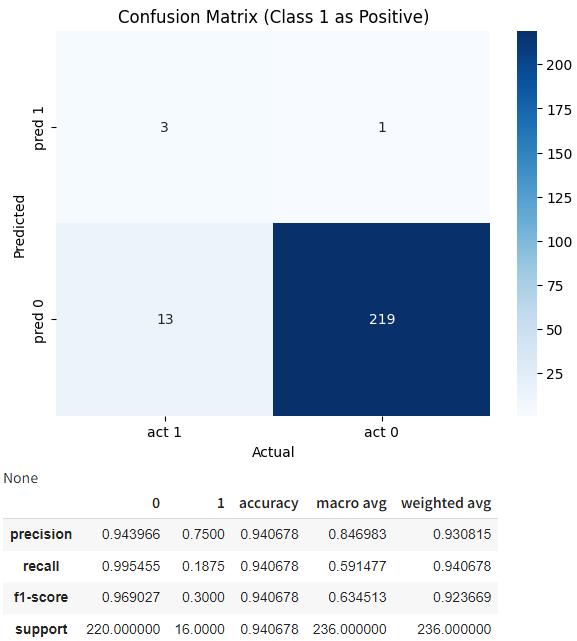

In [ ]:
# EOS

# 드롭아웃/배치정규화 효과 비교
- 배치 정규화: 학습 안정성 증가, 학습속도 중가, 과적합 감소(조금)
- 드롭아웃: 과적합 감소, 학습 안정성(간접효과..)

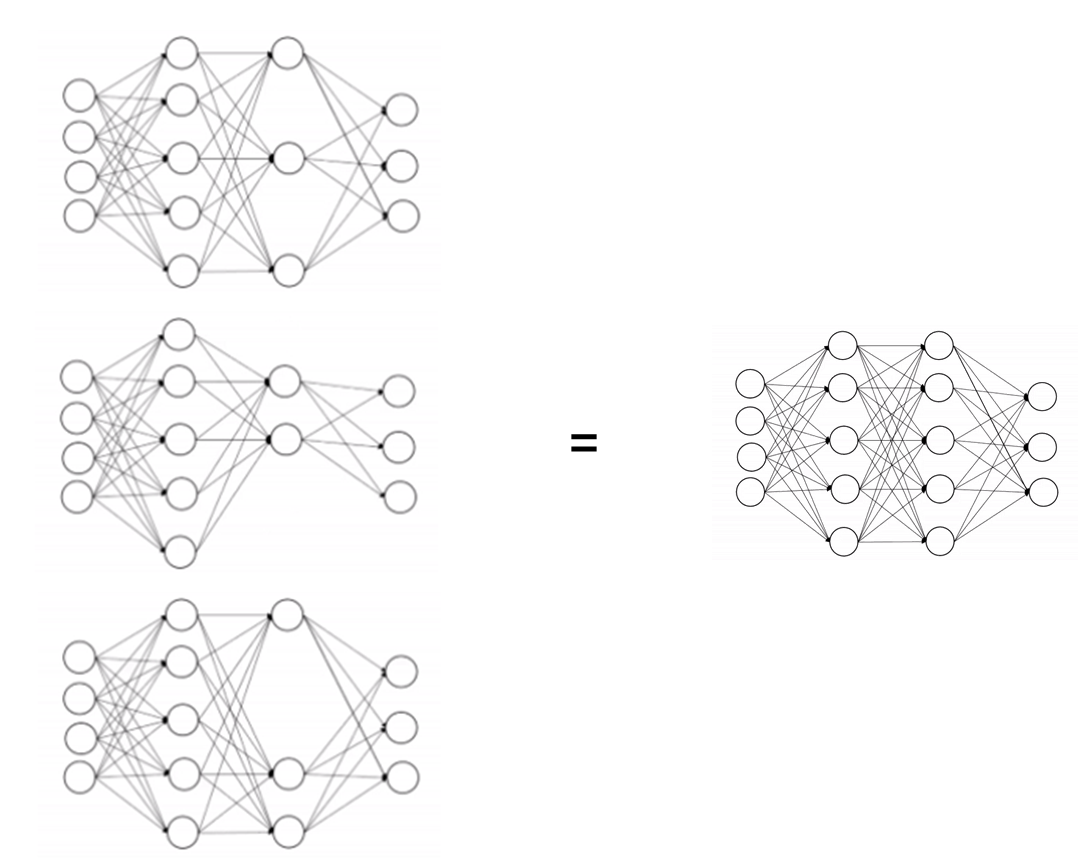

In [ ]:
# import torch.nn as nn

## DNN 모델 클래스 정의 (드롭아웃 및 배치 정규화 추가)
class DNN_dropout_batchNorm(nn.Module):
    def __init__(self, input_size, hidden_layers, hidden_units, output_size=1, dropout_prob = 0.5):
        super(DNN_dropout_batchNorm, self).__init__()

        # 입력층 정의
        layers = []
        current_input_size = input_size

        for i in range(hidden_layers):
            layers.append(nn.Linear(current_input_size, hidden_units[i]))
            layers.append(nn.BatchNorm1d(hidden_units[i]))      # 배치 정규화 추가
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p = dropout_prob))             # 드롭아웃 추가
            current_input_size = hidden_units[i]

        # 출력층 정의
        layers.append(nn.Linear(current_input_size, output_size))
        layers.append(nn.Sigmoid())  # 이진 분류를 위한 시그모이드 활성화 함수

        # 모델 구성
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [ ]:
## 모델 초기화 함수 정의
def initialize_model2(input_size, hidden_layers, hidden_units, output_size = 1, dropout_prob = 0.5 ):
    # 모델 생성
    model = DNN_dropout_batchNorm(input_size, hidden_layers, hidden_units, output_size, dropout_prob)
    return model

In [ ]:
## 드롭아웃 및 배치 정규화가 적용된 모델 초기화
dropout_prob = 0.5
model_with_dropout_bn = initialize_model2(input_size, hidden_layers, hidden_units, output_size=1)
optimizer_with_dropout_bn = optim.Adam(model_with_dropout_bn.parameters(), lr=0.01)

## 드롭아웃 및 배치 정규화가 없는 모델 초기화
model_without_dropout_bn = initialize_model(input_size, hidden_layers, hidden_units, output_size=1)
optimizer_without_dropout_bn = optim.Adam(model_without_dropout_bn.parameters(), lr=0.01)

## 학습 설정
num_epochs = 200

## 모델 학습 (드롭아웃 & 배치 정규화 적용된 모델)
loss_history_with_dropout_bn, trained_model_with_dropout_bn = train_model(
          model = model_with_dropout_bn,
          train_loader = train_loader,
          criterion = criterion,
          optimizer = optimizer_with_dropout_bn,
          num_epochs = num_epochs
)

## 모델 학습 (드롭아웃 & 배치 정규화 없는 모델)
loss_history_without_dropout_bn, trained_model_without_dropout_bn  =  train_model(
          model = model_without_dropout_bn,
          train_loader = train_loader,
          criterion = criterion,
          optimizer = optimizer_without_dropout_bn,
          num_epochs = num_epochs
)


Epoch: [1/200], Loss:  0.6734
Epoch: [2/200], Loss:  0.5980
Epoch: [3/200], Loss:  0.5268
Epoch: [4/200], Loss:  0.4022
Epoch: [5/200], Loss:  0.3217
Epoch: [6/200], Loss:  0.3683
Epoch: [7/200], Loss:  0.3245
Epoch: [8/200], Loss:  0.4094
Epoch: [9/200], Loss:  0.2128
Epoch: [10/200], Loss:  0.3684
Epoch: [11/200], Loss:  0.2836
Epoch: [12/200], Loss:  0.2652
Epoch: [13/200], Loss:  0.2410
Epoch: [14/200], Loss:  0.3112
Epoch: [15/200], Loss:  0.2329
Epoch: [16/200], Loss:  0.2798
Epoch: [17/200], Loss:  0.3085
Epoch: [18/200], Loss:  0.3076
Epoch: [19/200], Loss:  0.1714
Epoch: [20/200], Loss:  0.2257
Epoch: [21/200], Loss:  0.3028
Epoch: [22/200], Loss:  0.2462
Epoch: [23/200], Loss:  0.2045
Epoch: [24/200], Loss:  0.2057
Epoch: [25/200], Loss:  0.2465
Epoch: [26/200], Loss:  0.1792
Epoch: [27/200], Loss:  0.1264
Epoch: [28/200], Loss:  0.1957
Epoch: [29/200], Loss:  0.1887
Epoch: [30/200], Loss:  0.1712
Epoch: [31/200], Loss:  0.1810
Epoch: [32/200], Loss:  0.0887
Epoch: [33/200], 

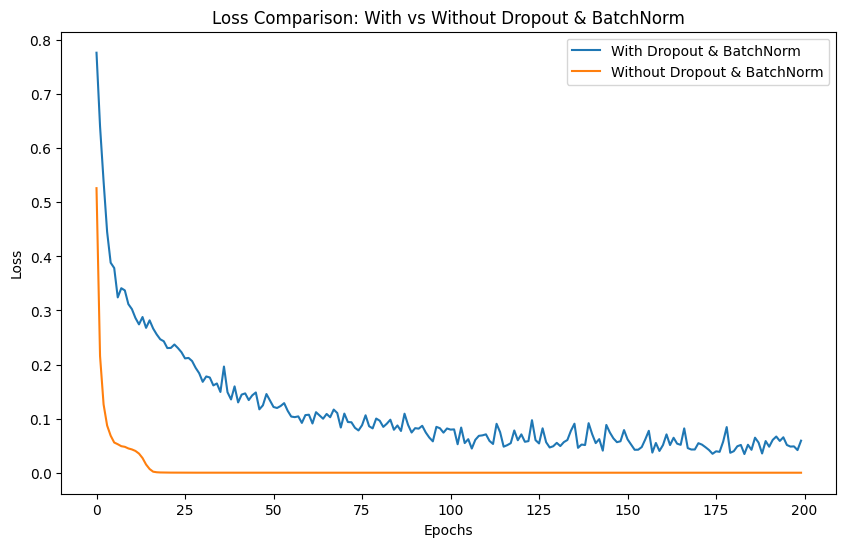

In [ ]:
## 학습 손실 비교
## 에폭~loss 그래프
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history_with_dropout_bn, label='With Dropout & BatchNorm')
plt.plot(loss_history_without_dropout_bn, label='Without Dropout & BatchNorm')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Comparison: With vs Without Dropout & BatchNorm')
plt.legend()
plt.show()


- Dropout과 Batch Normalization을 사용한 모델
  - 손실 값이 느리게 감소하지만 더 안정적
  - 과적합이 적을 가능성이 높음
- Dropout과 Batch Normalization을 사용하지 않은 모델
  -  매우 빠르게 학습되고 손실 값이 급격히 줄어듦
  - 학습 데이터에 과적합되었을 가능성이 높음..

In [ ]:
# EOS